# Phase Estimation

## Input
1. An known unitary $U$ and its eigenstate $\vert\psi\rangle$ with $U\vert\psi\rangle=e^{2\pi i\theta}\vert\psi\rangle$

## Goal
1. Estimate $\theta$
2. Extensiblity:
    - can choose the number of qubit for the first register in order to accommodate to contrains in qubit available.
3. Error Assessment:
    - Submit the circuit to simulator and actual quantum computers several time to get distribution of the error.

## Cicuit Construction
### package

In [11]:
import numpy as np
from math import pi
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, BasicAer, execute, IBMQ
from qiskit.visualization import plot_bloch_multivector, plot_histogram

### Circuit init

In [12]:
def pe_circ_init(size:int):
    #quantum register and  single state for storing eigen-state
    qr = QuantumRegister(size)
    psi = QuantumRegister(1,name="psi")
    #classical bits for readout
    cr = ClassicalRegister(size)
    
    qc = QuantumCircuit(qr,psi,cr)
    # apply Hadamards and init the eigenstate as |1>
    for i in range(size):
        qc.h(i)
    qc.x(size)
    
    qc.barrier()
    
    return qc

### Random Parameter 

In [13]:
k = np.random.random()
print(k)

0.21323313864714377


### Fixed Parameter

In [80]:
# It's size of the first register
# thus the total size of the circuit will be (2*size_reg + 1)
k = 1/8
size_reg = 4

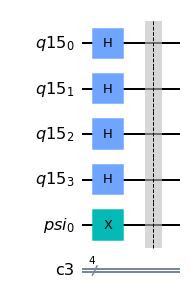

In [81]:
qc = pe_circ_init(size_reg)
qc.draw("mpl")

In [82]:
def C_U(circuit:QuantumCircuit, size:int, k:float):
    
    rep = 1
    for counting_qubit in range(size):
        for i in range(rep):
            circuit.cu1(2*pi*k, counting_qubit, size)
        rep *= 2
    
    circuit.barrier()
    
    return 

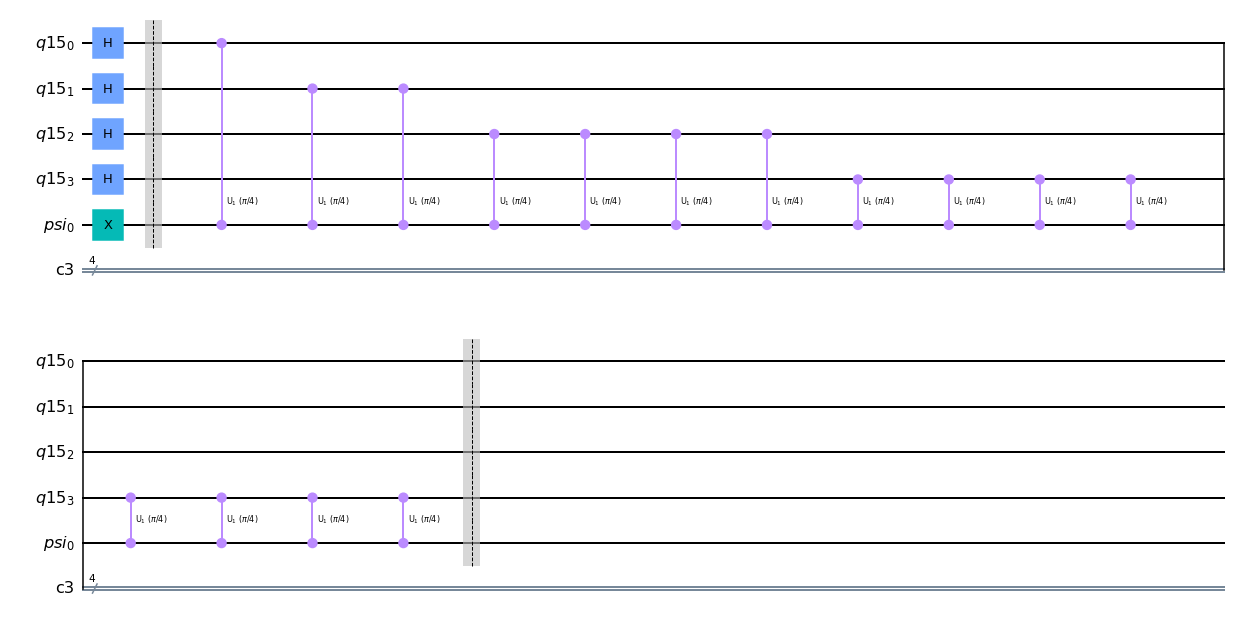

In [83]:
C_U(qc, size_reg,k)
qc.draw("mpl")

In [84]:
def qft_dagger(qc:QuantumCircuit,size:int):
    
    for qubit in range(size//2):
        qc.swap(qubit,size-qubit-1)
    for j in range(size):
        for m in range(j):
            qc.cu1(-pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.barrier()
    return

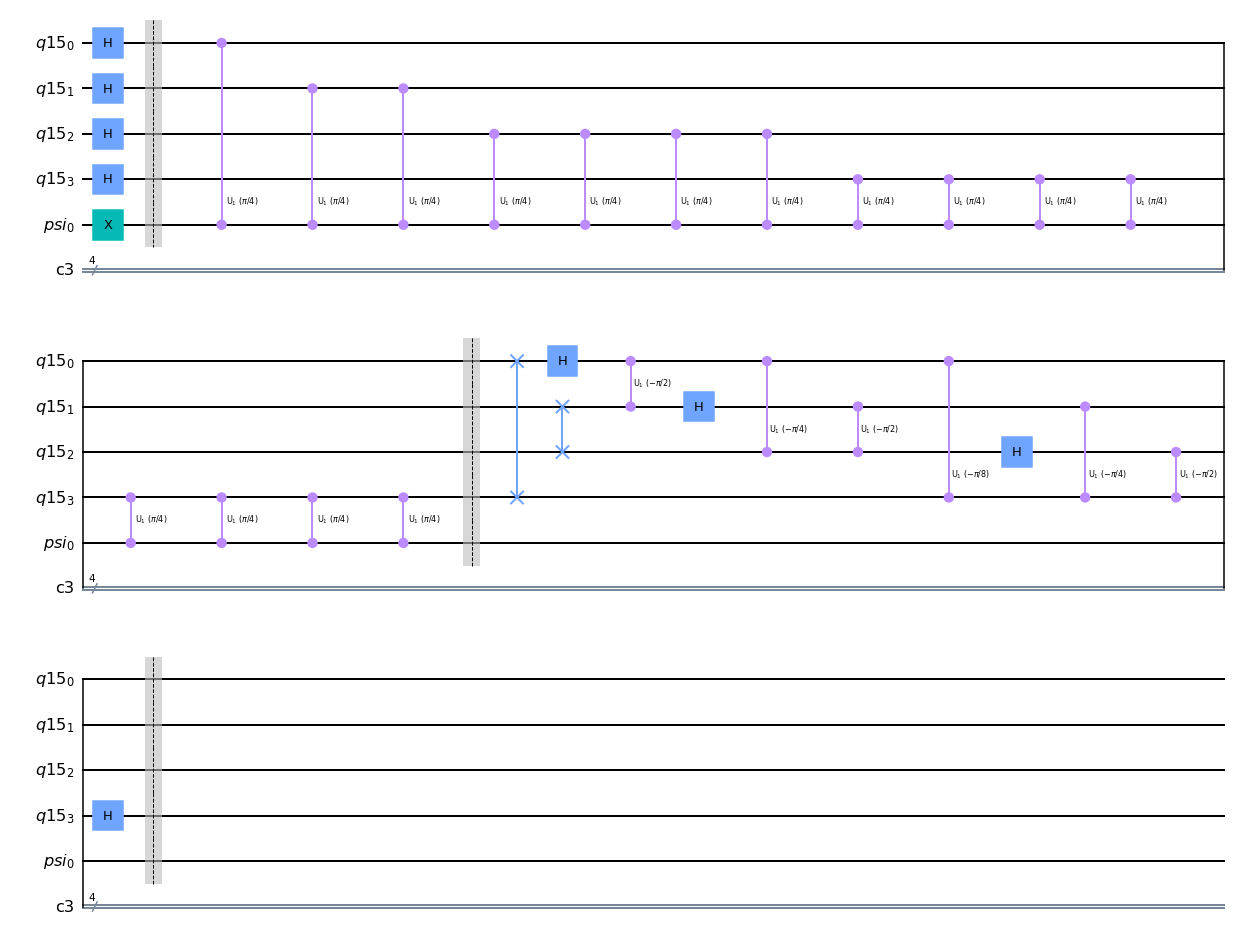

In [85]:
qft_dagger(qc,size_reg)
qc.draw("mpl")

In [86]:
def readout(qc:QuantumCircuit,size:int):
    for i in range(size):
        qc.measure(i,i)
    return

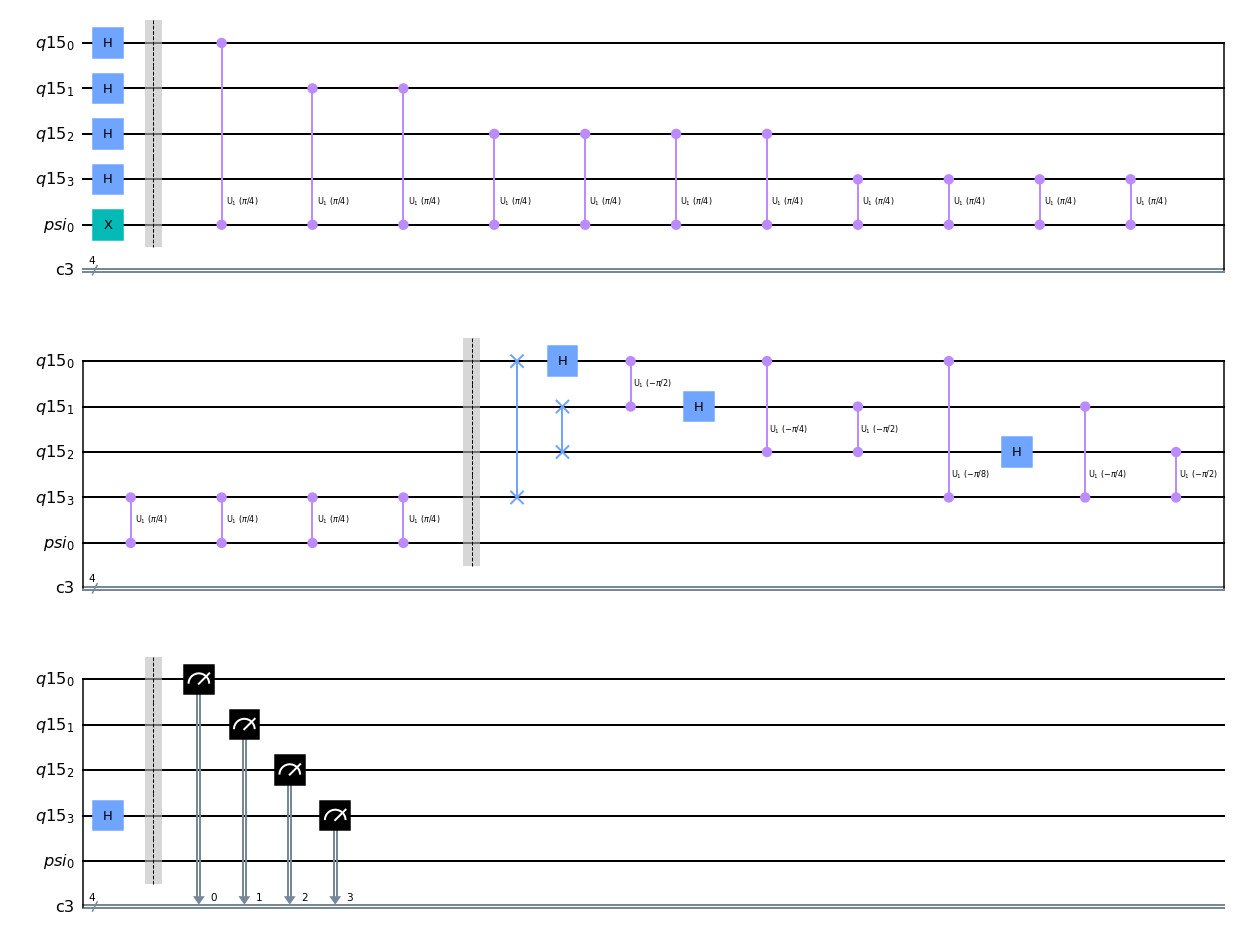

In [87]:
readout(qc,size_reg)
qc.draw("mpl")

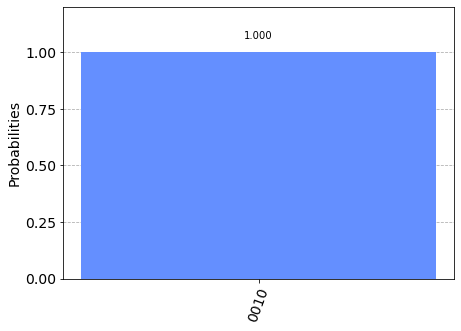

In [88]:
back_end = BasicAer.get_backend("qasm_simulator")
result = execute(qc,backend=back_end,shots=2048).result()
counts = result.get_counts()
plot_histogram(counts)

In [95]:
def counts_decode(counts):
    dt = {}
    total_len = 0
    for key in counts:
        if len(key) > total_len:
            total_len = len(key)
        int_key = int(key)
        decimal_key = 0.0
        for i in range(total_len):
            b = int_key%10
            ex = i - total_len
            decimal_key += b*(2**ex)
            int_key = int_key//10
        dt[decimal_key] = counts[key]
    return dt

In [96]:
dt = counts_decode(counts)
print(dt)

{0.125: 2048}


In [97]:
def expectation(decode_counts):
    res = 0.0
    total = 0
    for key in decode_counts:
        total += decode_counts[key]
        res += key*decode_counts[key]
    return res/total

In [98]:
expectation_val = expectation(dt)

In [99]:
print(expectation_val)

0.125
